# Load Frequency Control in ANDES

This examples shows (1) how to trip a generator, and (2) how to drive frequency back by load shedding.

In [1]:
import andes
import numpy as np

andes.config_logger(stream_level=20)

## Tripping a Generator in the IEEE 14-Bus System

In [2]:
# using the IEEE 14-bus model as an example. 
# The example here contains a variety of models: generators, exciters, turbine governors, and PSS
# To speed up, one can remove unneeded ones, e.g., PSS

ieee14_raw = andes.get_case("ieee14/ieee14.raw")
ieee14_dyr = andes.get_case("ieee14/ieee14.dyr")

In [3]:
# use `andes.load` to load the test system
# Need to set `setup=False` to be able to add new Togglers that turns off generators.

ss = andes.load(ieee14_raw, addfile=ieee14_dyr, setup=False)

Working directory: "/home/hcui7/repos/andes/examples"


Loaded config from file "/home/hcui7/.andes/andes.rc"


Loaded generated Python code in "~/.andes/pycode".


Parsing input file "/home/hcui7/repos/andes/andes/cases/ieee14/ieee14.raw"...


  IEEE 14 BUS TEST CASE


  03/06/14 CONTO           100.0  1962 W


Input file parsed in 0.0049 seconds.


Parsing additional file "/home/hcui7/repos/andes/andes/cases/ieee14/ieee14.dyr"...


Addfile parsed in 0.2090 seconds.


In [4]:
# Add a Toggler that disconnects `GENROU_2` at t=1 s

ss.add("Toggler", dict(model='SynGen', dev="GENROU_2", t=1.0))

'Toggler_3'

In [5]:
# Call setup manually

ss.setup()

IEEEST <IEEEST_1> added BusFreq <BusFreq_1> linked to bus <3.0>


ST2CUT <ST2CUT_2> added BusFreq <BusFreq_2> linked to bus <1.0>


ST2CUT <ST2CUT_3> added BusFreq <BusFreq_3> linked to bus <2.0>


System internal structure set up in 0.0463 seconds.


True

In [6]:
# double check that Togglers are set up correctly
# Check `u` of the Togglers - the first two line switches are disabled, and the generator trip is enabled

ss.Toggler.as_df()

,idx,u,name,model,dev,t
uid,,,,,,
0,Toggler_1,1.0,Toggler_1,Line,Line_1,1.0
1,Toggler_2,1.0,Toggler_2,Line,Line_1,1.1
2,Toggler_3,1.0,Toggler_3,SynGen,GENROU_2,1.0


In [7]:
# disable existing line switches
# The IEEE 14-bus system contains predefined line switches. Disabling them to study generator trip only.

ss.Toggler.u.v[[0, 1]] = 0

In [8]:
# calculate power flow

# use constant power model for PQ (we will come back to this later)

ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
ss.PQ.pq2z = 0

ss.PFlow.run()

-> System connectivity check results:


  No islanded bus detected.


  A total of 1 island(s) detected.


  Each island has a slack bus correctly defined and enabled.



-> Power flow calculation
   Sparse solver: KLU
 Solution method: NR method
 Sparse addition: Fast in-place (kvxopt)


Numba compilation initiated, parallel=False, cache=True.


Power flow initialized.


0: |F(x)| = 0.5605182134


1: |F(x)| = 0.006202200332


2: |F(x)| = 5.819382827e-06


3: |F(x)| = 6.957087684e-12


Converged in 4 iterations in 0.0072 seconds.


Numba compilation initiated, parallel=False, cache=True.


/home/hcui7/.andes/pycode/ESST3A.py:18: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "g_update" failed type inference due to: No implementation of function Function(<function select at 0x7f5e7403dc10>) found for signature:
 
 >>> select(list(array(bool, 1d, C))<iv=None>, LiteralList((Literal[int](1), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), Literal[int](0))), default=float64)
 
There are 2 candidate implementations:
  - Of which 1 did not match due to:
  Overload in function 'np_select': File: numba/np/arraymath.py: Line 4292.
    With argument(s): '(list(array(bool, 1d, C))<iv=None>, Poison<LiteralList((Literal[int](1), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), Literal[int](0)))>, default=float64)':
   Rejected as the implementation raised a specific error:
     TypingError: Poison type used in arguments; got Poison<LiteralList((Literal[int](1), array(float64, 1d, C), array(fl

/home/hcui7/mambaforge/envs/a/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "g_update" was compiled in object mode without forceobj=True.

File "../../../.andes/pycode/ESST3A.py", line 18:

def g_update(VB_y, LAW2_y, vout, UEL, UEL0, IN, XadIfd, ue, KC, VE, FEX_y, VB_x, VB_lim_zi, VBMAX, VB_lim_zu, VG_x, KG, VG_y, VGMAX, VG_lim_zu, VG_lim_zi, LAW1_y, vrs, vref, vref0, vi, LG_y, VIMIN, HLI_zi, HLI_zl, VIMAX, HLI_zu, vil, HG_sl_s0, HG_sl_s1, HG_y, TC, TB, LL_x, LL_LT1_z1, LL_LT2_z1, LL_y, vf0):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/hcui7/mambaforge/envs/a/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

/home/hcui7/.andes/pycode/ESST3A.py:30: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "gy_update" failed type inference due to: No implementation of function Function(<function select at 0x7f5e7403dc10>) found for signature:
 
 >>> select(LiteralList((array(bool, 1d, C), array(bool, 1d, C), array(bool, 1d, C), array(bool, 1d, C), Literal[bool](True))), LiteralList((Literal[int](0), float64, array(float64, 1d, C), float64, Literal[int](0))), default=float64)
 
There are 2 candidate implementations:
    - Of which 1 did not match due to:
    Overload in function 'np_select': File: numba/np/arraymath.py: Line 4292.
      With argument(s): '(Poison<LiteralList((array(bool, 1d, C), array(bool, 1d, C), array(bool, 1d, C), array(bool, 1d, C), Literal[bool](True)))>, Poison<LiteralList((Literal[int](0), float64, array(float64, 1d, C), float64, Literal[int](0)))>, default=float64)':
     Rejected as the implementation raised a specific error

/home/hcui7/mambaforge/envs/a/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "gy_update" was compiled in object mode without forceobj=True.

File "../../../.andes/pycode/ESST3A.py", line 30:

def gy_update(LAW2_y, VE, ue, KC, IN, VB_lim_zi, KG, VG_lim_zi, HLI_zi, HG_sl_s0, HG_sl_s1, TC, TB, LL_LT1_z1, LL_LT2_z1):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/hcui7/mambaforge/envs/a/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../.andes/pycode/ESST3A.py", line 30:

def gy_update(LAW2_y, VE, ue, KC, IN, VB_lim_zi, KG, VG_lim_zi, HLI_zi, HG_sl_s0, HG_sl_s1, TC, TB, LL_LT1_z1, LL_LT2_z1):
^

  war

Initialization for dynamics was successful in 17.9066 seconds.


Report saved to "ieee14_out.txt" in 0.0032 seconds.


True

In [9]:
# set the first simulation stop and run it

ss.TDS.config.tf = 20

ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-20 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|                                          | 0/100 [00:00<?, ?%/s]

<Toggler Toggler_3>: SynGen.GENROU_2 status changed to 0 at t=1.0 sec.
  5%|█▋                                | 5/100 [00:00<00:00, 96.65%/s]

  7%|██▍                               | 7/100 [00:00<00:01, 58.14%/s]

 13%|████▎                            | 13/100 [00:00<00:01, 45.10%/s]

 18%|█████▉                           | 18/100 [00:00<00:01, 43.51%/s]

 23%|███████▌                         | 23/100 [00:00<00:01, 42.19%/s]

 28%|█████████▏                       | 28/100 [00:00<00:01, 42.08%/s]

 33%|██████████▉                      | 33/100 [00:00<00:01, 41.94%/s]

 38%|████████████▌                    | 38/100 [00:00<00:01, 43.83%/s]

 43%|██████████████▏                  | 43/100 [00:00<00:01, 42.32%/s]

 48%|███████████████▊                 | 48/100 [00:01<00:01, 42.61%/s]

 53%|█████████████████▍               | 53/100 [00:01<00:01, 42.17%/s]

 58%|███████████████████▏             | 58/100 [00:01<00:01, 34.51%/s]

 64%|█████████████████████            | 64/100 [00:01<00:00, 38.84%/s]

 69%|██████████████████████▊          | 69/100 [00:01<00:00, 39.35%/s]

 74%|████████████████████████▍        | 74/100 [00:01<00:00, 41.96%/s]

 79%|██████████████████████████       | 79/100 [00:01<00:00, 43.12%/s]

 84%|███████████████████████████▋     | 84/100 [00:02<00:00, 38.72%/s]

 89%|█████████████████████████████▎   | 89/100 [00:02<00:00, 38.75%/s]

 93%|██████████████████████████████▋  | 93/100 [00:02<00:00, 38.03%/s]

 97%|████████████████████████████████ | 97/100 [00:02<00:00, 32.23%/s]

100%|████████████████████████████████| 100/100 [00:02<00:00, 38.24%/s]

Simulation completed in 2.6159 seconds.


Outputs to "ieee14_out.lst" and "ieee14_out.npz".


Outputs written in 0.0448 seconds.


True

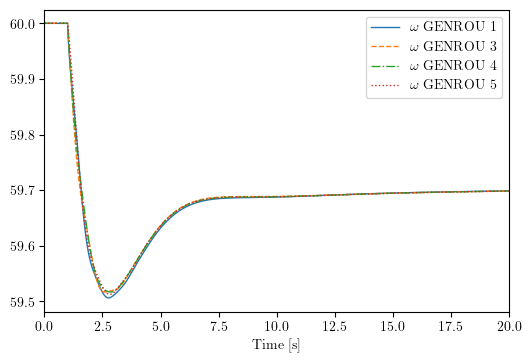

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [10]:
# Show the frequency response of online generators

# Refer to `plot` documentation by using `help(ss.TDS.plt.plot)` and `help(ss.TDS.plt.plot_data)`
ss.TDS.load_plotter()

ss.TDS.plt.plot(ss.GENROU.omega,
                a=(0, 2, 3, 4),
                ytimes=60,
               )

## Adjusting Load to Compensate for the Generation Loss

Check the power of the lost generator by inspecting the power flow inputs:

In [11]:
ss.PV.as_df()

,idx,u,name,Sn,Vn,bus,busr,p0,q0,pmax,pmin,qmax,qmin,v0,vmax,vmin,ra,xs
uid,,,,,,,,,,,,,,,,,,
0,2,0.0,2,100.0,69.0,2,None,0.40,0.15,0.5,0.1,0.15,-0.40,1.03,1.4,0.6,0.0,0.13
1,3,0.0,3,100.0,69.0,3,None,0.40,0.15,0.5,0.1,0.15,-0.10,1.01,1.4,0.6,0.0,0.13
2,4,0.0,4,100.0,138.0,6,None,0.30,0.10,0.5,0.1,0.10,-0.06,1.03,1.4,0.6,0.0,0.12
3,5,0.0,5,100.0,69.0,8,None,0.35,0.10,0.5,0.1,0.10,-0.06,1.03,1.4,0.6,0.0,0.12


The tripped GENROU_2 correspond to the first PV (GENROU_1 corresponds to Slack). Thus, the lost active power is 0.40 pu.

Let's compensate for that by shedding 0.4 pu of active power load at t=2.0 s.

By checking the equation documentation of PQ (using `print(ss.PQ.doc())`, we can tell that the imposed active power for time-domain simulation is from `Ppf`, because we used the constant power model with `p2p = 1`.

```
Algebraic Equations

Name |   Type   |                RHS of Equation "0 = g(x, y)"                
-----+----------+-------------------------------------------------------------
 a   | ExtAlgeb | u * (dae_t <= 0) * (p0 * vcmp_zi + Rlb * vcmp_zl * v**2 +   
     |          | Rub * vcmp_zu * v**2) + u * (dae_t > 0) * (p2p * Ppf + p2i *
     |          | Ipeq * v + p2z * Req * v**2)                                
 v   | ExtAlgeb | u * (dae_t <= 0) * (q0 * vcmp_zi + Xlb * vcmp_zl * v**2 +   
     |          | Xub * vcmp_zu * v**2) + u * (dae_t > 0) * (q2q * Qpf + q2i *
     |          | Iqeq * v + q2z * Xeq * v**2)                                

```

`Ppf` may be different from `p0` specified in the data file.

In [12]:
# active power from power flow solution - make a copy

Ppf = np.array(ss.PQ.Ppf.v)

Ppf

array([0.217, 0.5  , 0.478, 0.076, 0.15 , 0.295, 0.09 , 0.035, 0.061,
       0.135, 0.2  ])

Reload the system and add the generator trip.

In [13]:
ss = andes.load(ieee14_raw, addfile=ieee14_dyr, setup=False)

ss.add("Toggler", dict(model='SynGen', dev="GENROU_2", t=1.0))
ss.setup()
ss.Toggler.u.v[[0, 1]] = 0


ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0

ss.PFlow.run()

Working directory: "/home/hcui7/repos/andes/examples"


Loaded config from file "/home/hcui7/.andes/andes.rc"


Loaded generated Python code in "~/.andes/pycode".


Parsing input file "/home/hcui7/repos/andes/andes/cases/ieee14/ieee14.raw"...


  IEEE 14 BUS TEST CASE


  03/06/14 CONTO           100.0  1962 W


Input file parsed in 0.0081 seconds.


Parsing additional file "/home/hcui7/repos/andes/andes/cases/ieee14/ieee14.dyr"...


Addfile parsed in 0.3892 seconds.


IEEEST <IEEEST_1> added BusFreq <BusFreq_1> linked to bus <3.0>


ST2CUT <ST2CUT_2> added BusFreq <BusFreq_2> linked to bus <1.0>


ST2CUT <ST2CUT_3> added BusFreq <BusFreq_3> linked to bus <2.0>


System internal structure set up in 0.0303 seconds.


-> System connectivity check results:


  No islanded bus detected.


  A total of 1 island(s) detected.


  Each island has a slack bus correctly defined and enabled.



-> Power flow calculation
   Sparse solver: KLU
 Solution method: NR method
 Sparse addition: Fast in-place (kvxopt)


Numba compilation initiated, parallel=False, cache=True.


Power flow initialized.


0: |F(x)| = 0.5605182134


1: |F(x)| = 0.006202200332


2: |F(x)| = 5.819382827e-06


3: |F(x)| = 6.957087684e-12


Converged in 4 iterations in 0.0044 seconds.


Numba compilation initiated, parallel=False, cache=True.


Initialization for dynamics was successful in 0.2978 seconds.


Report saved to "ieee14_out.txt" in 0.0052 seconds.


True

But let's run to 2 seconds.

In [14]:
ss.TDS.config.tf = 2.0

ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-2.0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|                                          | 0/100 [00:00<?, ?%/s]

<Toggler Toggler_3>: SynGen.GENROU_2 status changed to 0 at t=1.0 sec.
 31%|█████████▉                      | 31/100 [00:00<00:00, 696.89%/s]

 40%|████████████▊                   | 40/100 [00:00<00:00, 376.85%/s]

 66%|█████████████████████           | 66/100 [00:00<00:00, 297.71%/s]

Simulation completed in 0.2225 seconds.


Outputs to "ieee14_out.lst" and "ieee14_out.npz".


Outputs written in 0.0059 seconds.


True

In [15]:
# all `Ppf` before shedding

ss.PQ.Ppf.v

array([0.217, 0.5  , 0.478, 0.076, 0.15 , 0.295, 0.09 , 0.035, 0.061,
       0.135, 0.2  ])

And then apply the load shedding on buses 2, 3, 4, 5, 6, 9.

In [16]:
shed_buses = [2, 3, 4, 5, 6, 9]

# find the `idx` of the loads on these buses

pq_shed_idx = ss.PQ.find_idx(keys='bus', values=shed_buses)
pq_shed_idx

['PQ_1', 'PQ_2', 'PQ_3', 'PQ_4', 'PQ_5', 'PQ_6']

In [17]:
# get `Ppf` on these buses before shedding

pq_p = ss.PQ.get(src='Ppf', idx=pq_shed_idx, attr='v')
pq_p

array([0.217, 0.5  , 0.478, 0.076, 0.15 , 0.295])

In [18]:
pq_p_new = pq_p - 0.4 / len(shed_buses)

ss.PQ.set(src='Ppf', idx=pq_shed_idx, attr='v', value=pq_p_new)

True

In [19]:
# double check

ss.PQ.Ppf.v

array([0.15033333, 0.43333333, 0.41133333, 0.00933333, 0.08333333,
       0.22833333, 0.09      , 0.035     , 0.061     , 0.135     ,
       0.2       ])

  0%|                                          | 0/100 [00:00<?, ?%/s]

 13%|████                           | 13.0/100 [00:00<00:00, 93.56%/s]

 23%|███████▏                       | 23.0/100 [00:00<00:01, 46.02%/s]

 29%|████████▉                      | 29.0/100 [00:00<00:01, 40.49%/s]

 34%|██████████▌                    | 34.0/100 [00:00<00:01, 37.89%/s]

 39%|████████████                   | 39.0/100 [00:00<00:01, 38.25%/s]

 43%|█████████████▎                 | 43.0/100 [00:01<00:01, 36.04%/s]

 47%|██████████████▌                | 47.0/100 [00:01<00:01, 36.37%/s]

 51%|███████████████▊               | 51.0/100 [00:01<00:01, 37.10%/s]

 55%|█████████████████              | 55.0/100 [00:01<00:01, 34.98%/s]

 60%|██████████████████▌            | 60.0/100 [00:01<00:01, 38.04%/s]

 64%|███████████████████▊           | 64.0/100 [00:01<00:01, 33.53%/s]

 68%|█████████████████████          | 68.0/100 [00:01<00:01, 31.86%/s]

 73%|██████████████████████▋        | 73.0/100 [00:01<00:00, 36.09%/s]

 78%|████████████████████████▏      | 78.0/100 [00:02<00:00, 37.77%/s]

 83%|█████████████████████████▋     | 83.0/100 [00:02<00:00, 38.51%/s]

 87%|██████████████████████████▉    | 87.0/100 [00:02<00:00, 34.17%/s]

 91%|████████████████████████████▏  | 91.0/100 [00:02<00:00, 34.03%/s]

 95%|█████████████████████████████▍ | 95.0/100 [00:02<00:00, 33.30%/s]

 99%|██████████████████████████████▋| 99.0/100 [00:02<00:00, 34.10%/s]

100%|██████████████████████████████| 100.0/100 [00:02<00:00, 37.02%/s]

Simulation completed in 2.7022 seconds.


Outputs to "ieee14_out.lst" and "ieee14_out.npz".


Outputs written in 0.0868 seconds.


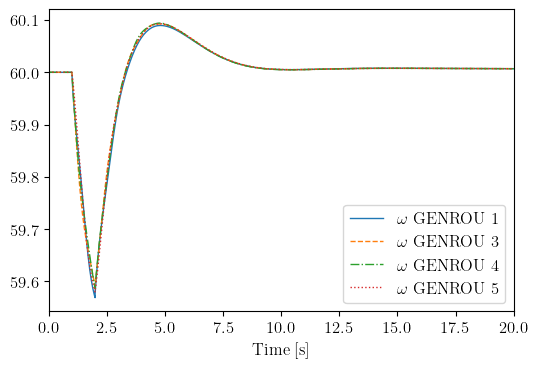

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [20]:
ss.TDS.config.tf = 20

ss.TDS.run()


ss.TDS.plt.plot(ss.GENROU.omega,
                a=(0, 2, 3, 4),
                ytimes=60,
               )

In [21]:
!andes misc -C


    _           _         | Version 1.4.2.post33.dev0+g135cb3eb
   /_\  _ _  __| |___ ___ | Python 3.9.6 on Linux, 09/19/2021 05:23:44 PM
  / _ \| ' \/ _` / -_|_-< | 
 /_/ \_\_||_\__,_\___/__/ | This program comes with ABSOLUTELY NO WARRANTY.

No output file found in the working directory.


The result shows the generator speed (frequency) returns to 60 Hz after load shedding. 